In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import math

## Data cleaning

The following cells will improve the DF, which presents inconsistency, missing values and outliers, thanks to consideration done during the data understanding phase

In [2]:
# load df
df = pd.read_csv("../dataset/customer_supermarket_regex.csv", index_col=0, parse_dates=["BasketDate"], decimal=",")

In [3]:
#delete every row with Qta <= 0
print("DF len before deleting rows with Qta  <= 0", len(df))
df = df[df['Qta'] > 0]
print("DF len after deleting rows with Qta  <= 0", len(df))

DF len before deleting rows with Qta  <= 0 396687
DF len after deleting rows with Qta  <= 0 387881


In [4]:
# inconsistency resolution

def inconsistency_resolver(path,col1,col2):
    
    with open(path, 'r') as f:
        inconsistent_list = json.load(f)
        
    df_inconsistent = df[df[col1].isin(inconsistent_list)]

    df_grouped = df_inconsistent.groupby([col1,col2]).size().reset_index()
    
    df_grouped = df_grouped.sort_values(0, ascending=False).drop_duplicates(col1).sort_index()
    
    mydict = pd.Series(df_grouped[col2].values,index=df_grouped[col1]).to_dict()
    
    for k,v in mydict.items():
        
        df.loc[df[col1] == k, col2] = v

inconsistency_resolver("../dataset/inconsistent_CustomerID_CustomerCountry.json","CustomerID","CustomerCountry") 
inconsistency_resolver("../dataset/inconsistent_ProdID_ProdDescr.json","ProdID","ProdDescr") 

In [5]:
def inconsistent_set(K,V):
    
    inconsistentset = list()

    for key in df[K].unique().tolist():
        temp_df = df[df[K] == key]
        valueslist = temp_df[V].tolist()
        for value in valueslist:
            if(valueslist[0] != value):
                inconsistentset.append(key)
                break;
    return inconsistentset


# 1
ProdID_ProdDescr_IS = inconsistent_set("ProdID","ProdDescr")
            
print("Number of not consistent ProdDescr:", len(ProdID_ProdDescr_IS))

#3 
CustomerID_CustomerCountry_IS = inconsistent_set("CustomerID","CustomerCountry")
            
print("Number of not consistent CustomerCountry:", len(CustomerID_CustomerCountry_IS))

Number of not consistent ProdDescr: 0
Number of not consistent CustomerCountry: 8


## Data recovery

Some rows from the initial database were partially completed, there were missing values. We want to recover these rows by checking if there are rows with missing values that are very close to rows without partial data.

In [ ]:
def similar_rows(basketID, basketDate):
    
    for i in tqdm(range(len(basketID))):
        temp_df = df[(df['BasketID'] == basketID[i]) & (df['BasketDate'] == basketDate[i])]
        if(len(temp_df) > 0):
            print(temp_df)
    
    
    
df_nan = pd.read_csv("../dataset/customer_supermarket_nan.csv", sep="\t", index_col=0, decimal=",")
print("Number of rows with nan values", len(df_nan))

#df_nan['CustomerID'] = df[df['BasketID'] == df_nan['BasketID']][0]['CustomerID']
similar_rows(df_nan.BasketID.values,df_nan.BasketDate.values)

is_NaN = df_nan.isnull()
row_has_NaN = is_NaN.any(axis=1)
print("Number of rows with nan values after matching partial rows with complete rows", len(df_nan[row_has_NaN]))


#duplicates_free = df_nan.drop_duplicates(subset=['BasketID','BasketDate','CustomerCountry','ProdID'])
#only_duplicates = df_nan[np.invert(df_nan.index.isin(duplicates_free.index))]
#df_nan_group = df_nan.groupby(['BasketID','BasketDate','CustomerCountry','ProdID']).size()

#df_nan['CustomerID'] = df[df['BasketID'] == df_nan['BasketID'] & df['BasketDate'] == df_nan['BasketDate'] & df['CustomerCountry'] == df_nan['CustomerCountry']]['CustomerID']

DF without inconsistency serialization

In [7]:
df.to_csv("../dataset/customer_supermarket_no_inconsistency.csv", sep="\t", decimal=",")

## Indicators

In [8]:
# first of all we deserialize our dataframe
df = pd.read_csv("../dataset/customer_supermarket_no_inconsistency.csv", sep="\t", index_col=0, parse_dates=["BasketDate"], decimal=",")
print(df.head())
print(df.info())

   BasketID          BasketDate  ProdID  Qta  Sale  CustomerID  \
0    536365 2010-01-12 08:26:00   21730    6  4.25       17850   
1    536365 2010-01-12 08:26:00   22752    2  7.65       17850   
2    536365 2010-01-12 08:26:00   71053    6  3.39       17850   
3    536365 2010-01-12 08:26:00  84029E    6  3.39       17850   
4    536365 2010-01-12 08:26:00  84029G    6  3.39       17850   

  CustomerCountry                            ProdDescr  
0  United Kingdom    GLASS STAR FROSTED T-LIGHT HOLDER  
1  United Kingdom         SET 7 BABUSHKA NESTING BOXES  
2  United Kingdom                  WHITE METAL LANTERN  
3  United Kingdom       RED WOOLLY HOTTIE WHITE HEART.  
4  United Kingdom  KNITTED UNION FLAG HOT WATER BOTTLE  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 387881 entries, 0 to 387880
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         387881 non-null  int6

# I - indicator
the total number of items purchased by a customer during the period of
observation.

In [9]:
df_i = df.groupby("CustomerID").sum().reset_index()
df_i = df_i[["CustomerID", "Qta"]]
df_i

,CustomerID,Qta
0,12346,74215
1,12347,2458
2,12348,2341
3,12349,631
4,12350,197
...,...,...
4334,18280,45
4335,18281,54
4336,18282,103
4337,18283,1357


In [10]:
#!! look at this, it might be an outlier
print(df[df.CustomerID == 12346])

       BasketID          BasketDate ProdID    Qta  Sale  CustomerID  \
36061    541431 2011-01-18 10:01:00  23166  74215  1.04       12346   

      CustomerCountry                       ProdDescr  
36061  United Kingdom  MEDIUM CERAMIC TOP STORAGE JAR  


# Iu - indicator
the number of distinct items bought by a customer in the period of
observation.

In [11]:
df_iu = df.groupby('CustomerID')['ProdID'].nunique().reset_index()
df_iu

,CustomerID,ProdID
0,12346,1
1,12347,103
2,12348,22
3,12349,73
4,12350,17
...,...,...
4334,18280,10
4335,18281,7
4336,18282,12
4337,18283,263


# Imax - indicator
the maximum number of items purchased by a customer during a
shopping session

In [12]:
df_imax = df.groupby(["CustomerID", "BasketID"]).Qta.sum()
df_imax = df_imax.groupby(level=0).head(1).reset_index()

#df_imax = df_imax.max(level=0)

df_imax

,CustomerID,BasketID,Qta
0,12346,541431,74215
1,12347,537626,319
2,12348,539318,1254
3,12349,577609,631
4,12350,543037,197
...,...,...,...
4334,18280,545712,45
4335,18281,556464,54
4336,18282,562525,75
4337,18283,540350,61


# E - indicator
the Shannon entropy on the purchasing behaviour of the customer

In [13]:
df_temp = df.groupby(["CustomerID", "BasketID"]).Qta.sum().reset_index()
values = df_temp["Qta"]
df_temp['Entropy'] = -(values*np.log(values))
df_entropy = df_temp.groupby('CustomerID')['Entropy'].sum().reset_index()
# to remove nan values caused by logs
df_entropy['Entropy'] = df_entropy['Entropy'].fillna(0)


df_entropy

,CustomerID,Entropy
0,12346,-832300.560951
1,12347,-14642.853340
2,12348,-15464.124169
3,12349,-4068.249999
4,12350,-1040.791135
...,...,...
4334,18280,-171.299812
4335,18281,-215.405139
4336,18282,-417.113335
4337,18283,-6354.286026


### Putting together all indicators

In [14]:
frames = [df_entropy, df_imax.Qta, df_iu.ProdID, df_i.Qta]
indicators = pd.concat(frames, join='outer', axis=1)
indicators.columns = ("CustomerID", "Entropy", "imax", "iu", "i")
print(indicators.head())

indicators.to_csv("../dataset/indicators.csv")

   CustomerID        Entropy   imax   iu      i
0       12346 -832300.560951  74215    1  74215
1       12347  -14642.853340    319  103   2458
2       12348  -15464.124169   1254   22   2341
3       12349   -4068.249999    631   73    631
4       12350   -1040.791135    197   17    197


# Additional indicators

### Sales per country
(is this even an indicator?)

In [15]:
df

,BasketID,BasketDate,ProdID,Qta,Sale,CustomerID,CustomerCountry,ProdDescr
0,536365,2010-01-12 08:26:00,21730,6,4.25,17850,United Kingdom,GLASS STAR FROSTED T-LIGHT HOLDER
1,536365,2010-01-12 08:26:00,22752,2,7.65,17850,United Kingdom,SET 7 BABUSHKA NESTING BOXES
2,536365,2010-01-12 08:26:00,71053,6,3.39,17850,United Kingdom,WHITE METAL LANTERN
3,536365,2010-01-12 08:26:00,84029E,6,3.39,17850,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.
4,536365,2010-01-12 08:26:00,84029G,6,3.39,17850,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE
...,...,...,...,...,...,...,...,...
387876,581587,2011-09-12 12:50:00,22899,6,2.1,12680,France,CHILDREN'S APRON DOLLY GIRL
387877,581587,2011-09-12 12:50:00,23254,4,4.15,12680,France,CHILDRENS CUTLERY DOLLY GIRL
387878,581587,2011-09-12 12:50:00,23255,4,4.15,12680,France,CHILDRENS CUTLERY CIRCUS PARADE
387879,581587,2011-09-12 12:50:00,23256,4,4.15,12680,France,CHILDRENS CUTLERY SPACEBOY


In [16]:
df_sales_per_country = df.groupby(["CustomerCountry"])["Sale"].sum().reset_index()
print(df_sales_per_country)

         CustomerCountry                                               Sale
0              Australia  4.951.258.58.58.51.650.853.753.758.55.456.355....
1                Austria  4.253.752.952.950.851.458.540.01.951.950.850.8...
2                Bahrain  12.754.951.252.952.952.959.951.251.254.254.254...
3                Belgium  0.429.950.550.550.420.850.421.652.10.551.9518....
4                 Brazil  5.955.955.955.952.082.13.253.394.956.756.751.6...
5                 Canada  1.954.251.694.950.850.851.650.651.692.11.060.8...
6        Channel Islands  7.954.951.694.957.952.551.2514.9514.958.957.95...
7                 Cyprus  2.551.251.251.251.251.253.753.753.751.250.651....
8         Czech Republic  1.254.251.250.851.451.950.852.954.950.852.551....
9                Denmark  2.951.657.951.251.251.253.753.753.753.753.757....
10                  EIRE  8.958.952.252.251.691.251.251.451.950.850.651....
11    European Community  2.952.9512.752.953.9514.957.957.956.756.7518.0...
12          

ValueError: could not convert string to float: '4.951.258.58.58.51.650.853.753.758.55.456.355.955.956.752.951.651.651.250.365.951.257.951.651.650.850.853.756.752.951.951.061.061.066.750.720.720.721.451.451.451.061.061.061.451.851.451.451.653.390.851.850.554.251.851.851.851.851.851.850.721.061.063.391.061.656.754.253.450.721.651.651.652.952.551.690.371.250.850.851.651.651.652.952.252.252.251.252.952.951.950.850.851.651.651.453.753.753.752.952.952.951.950.851.654.252.954.953.952.953.751.450.850.852.951.454.655.455.450.850.951.951.951.251.651.652.952.952.950.852.11.6512.751.958.952.954.252.950.856.751.691.691.691.697.958.58.58.58.52.553.753.753.753.753.756.755.951.452.954.954.254.955.451.252.954.952.954.951.450.550.720.720.530.642.551.691.451.691.250.424.258.953.252.550.650.420.364.252.551.451.451.451.450.4210.954.250.361.450.724.254.251.651.651.658.58.57.650.721.451.954.951.452.552.552.552.552.550.363.454.656.956.955.955.950.723.750.720.728.51.252.754.250.340.340.423.753.752.551.452.952.952.951.954.956.755.951.951.061.061.060.720.530.644.258.953.250.720.720.721.451.451.450.360.361.061.060.250.250.360.360.360.360.360.340.342.552.551.062.552.552.552.551.4510.954.250.360.360.361.451.451.451.450.254.253.391.061.651.651.658.58.57.654.951.452.552.550.340.360.363.393.393.3914.9512.756.956.955.955.9514.9514.9514.953.751.258.51.253.391.451.063.752.951.950.851.654.952.952.954.950.851.252.957.957.950.850.854.252.951.656.755.958.258.258.255.455.457.95350.01.651.651.654.951.652.951.652.12.11.651.651.653.354.951.651.254.152.957.951.651.657.957.952.952.952.953.751.655.752.086.250.832.082.081.657.957.957.955.950.850.726.750.190.391.696.751.454.251.061.251.063.391.451.060.530.530.533.392.551.651.451.253.391.256.752.552.552.554.254.254.250.550.550.550.550.550.554.954.953.391.251.451.251.651.658.251.451.451.458.152.751.951.951.951.9512.56.754.153.391.254.154.654.656.751.251.255.955.950.380.380.381.951.250.00.3614.953.755.951.651.652.950.654.957.958.952.897.951.656.356.750.850.851.255.950.341.450.830.851.060.290.725.951.061.451.250.420.422.550.360.362.13.754.959.950.851.060.420.421.791.652.551.250.420.420.650.640.721.251.251.250.360.360.343.392.552.552.554.254.251.251.652.552.552.552.12.551.451.451.450.722.552.552.550.420.8510.950.550.360.360.421.450.721.651.651.651.652.550.340.340.340.364.253.393.393.390.722.553.751.252.11.451.0614.951.795.391.851.851.451.040.691.451.451.458.153.751.451.451.791.791.451.451.453.390.342.492.493.753.753.753.751.851.854.151.654.153.753.753.751.051.051.651.651.250.420.420.420.632.951.061.653.751.793.391.252.952.954.251.654.252.552.552.952.951.651.651.651.951.951.651.451.250.830.834.954.952.16.954.954.954.954.151.251.060.390.340.340.394.250.390.390.390.340.530.360.360.720.290.340.340.340.720.720.721.041.452.552.950.851.650.651.252.952.950.855.950.852.9511.157.452.892.894.954.951.651.253.750.830.830.831.251.654.952.552.492.494.955.455.450.850.951.257.951.652.950.427.954.954.953.750.424.954.952.950.423.753.754.653.751.654.153.254.957.951.251.651.251.450.4210.950.420.422.081.652.951.454.951.451.950.650.420.424.951.656.252.082.081.651.250.834.151.651.652.082.081.651.651.653.750.422.892.894.154.152.082.084.951.954.954.154.154.151.251.250.830.830.831.251.651.450.552.081.652.084.954.952.953.753.753.753.752.086.751.651.651.454.651.951.061.451.651.651.651.651.652.951.452.951.652.081.452.086.351.451.060.851.651.451.651.652.12.11.459.950.791.061.061.794.254.251.251.652.552.551.4510.950.550.361.451.454.253.391.651.651.456.752.552.552.554.252.491.451.451.451.453.392.550.722.553.7512.751.250.420.341.251.451.061.451.040.833.751.951.952.491.952.251.791.791.791.451.451.452.493.753.751.851.851.650.720.720.720.724.153.7510.390.550.633.391.451.791.081.081.250.721.651.040.340.344.151.791.060.551.453.390.361.041.250.721.452.082.082.081.651.651.651.252.087.957.950.850.650.651.651.650.399.957.951.251.250.421.252.12.14.950.425.950.422.894.154.150.850.850.850.830.830.831.254.953.753.758.252.951.252.952.952.954.253.952.952.892.894.952.081.650.630.633.390.834.955.451.250.851.251.652.951.652.951.651.651.651.250.850.552.251.651.251.651.650.552.951.652.12.11.651.953.751.454.158.34.154.153.451.791.451.061.065.954.954.251.069.950.362.557.657.657.652.551.7910.950.360.360.361.251.451.651.651.652.552.554.253.453.393.393.393.393.391.060.721.253.391.651.653.453.453.455.394.154.152.751.452.494.150.427.657.651.061.061.063.753.753.751.791.041.040.360.361.791.791.793.292.493.293.293.293.295.353.295.355.355.355.357.457.450.422.082.951.694.952.950.420.420.428.52.0812.758.253.753.754.954.959.958.54.954.152.081.250.422.085.955.952.082.086.255.955.952.890.421.792.080.03.290.01.791.451.061.454.251.650.721.450.722.551.451.451.451.651.651.651.651.451.791.451.453.291.254.654.657.080.421.792.950.190.390.855.950.852.952.95'

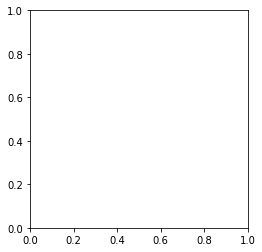

In [17]:
# the pie plot is horrible because of england, that probably has some outliers
#explode=np.zeros(len(df_sales_per_country.CustomerCountry))

plt.pie(df_sales_per_country.Sale, labels=df_sales_per_country.CustomerCountry, autopct='%1.1f%%')
plt.show()

### Most bought items

In [ ]:
cols_dropped = [2, 3, 6]
df_most_bought = df.groupby(["ProdID", "ProdDescr"]).sum().reset_index()
#df_most_bought = df_most_bought.drop(df_most_bought.columns[cols_dropped], axis=1)
df_most_bought = df_most_bought.sort_values(by="Qta", ascending=False)
#df_most_bought = df_most_bought.groupby(level=0).head(1).reset_index()
df_most_bought 

#print(df[df.ProdDescr == "Discount"])

In [ ]:
plt.pie(df_most_bought[:10].Qta, labels=df_most_bought[:10].ProdDescr, autopct='%1.1f%%')
plt.savefig("../output/most_bought_item_piechart.png")
plt.show()

### Most bought item per country


In [ ]:
#cols_dropped = [3, 4, 7]
df_mb_country = df.groupby(["ProdID", "ProdDescr", "CustomerCountry"]).sum().reset_index()
df_mb_country = df_mb_country.drop(["Sale"], axis = 1)

df_mb_country = df_mb_country[df_mb_country.groupby(["CustomerCountry"])["Qta"].transform("max") == df_mb_country["Qta"]].reset_index()

#df_mb_country = df_mb_country.groupby(["CustomerCountry"]).agg({"Qta" : "max"}).reset_index()
#print(df_mb_country.CustomerCountry.unique())


print(df_mb_country)


### Linear Graphs

In [ ]:
# start and end datetimes
print(df.BasketDate.min(), df.BasketDate.max())

In [ ]:
weekly = df.set_index("BasketDate").copy()
weekly = weekly.groupby(pd.Grouper(freq='M'))["Qta"].sum()

#print(weekly)

plt.figure(figsize=(16,5))
plt.plot(weekly.index, weekly, color='tab:blue', marker="o")